# Задача

На исследованном датасете [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction) обучить и проинтерпретировать их результаты.

Я сначала подготовлю данные к обучению, после чего обучу несколько интерпретируемых моделей, для того чтобы получить еще некоторые инсайды из данных.

In [1]:
import pandas as pd
import numpy as np
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.base import  clone
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv(r"..\data\raw\Churn_Modelling.csv", sep=',',index_col="RowNumber")
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
train.drop(columns=["CustomerId", "Surname"],inplace=True)

In [4]:
X = train.copy()
y = X.pop("Exited")

splits = 5
seed = 77
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)

In [5]:
def feature_generator(x):
    x_copy = x.copy()
    x_copy['IsActive_by_CreditCard'] = x_copy['HasCrCard'] * x_copy['IsActiveMember']
    x_copy['Products_Per_Tenure'] =  x_copy['Tenure'] / x_copy['NumOfProducts']
    x_copy['ZeroBalance'] = (x_copy['Balance'] == 0).astype(np.uint8)
    
    return x_copy


FeatureGenerator = FunctionTransformer(feature_generator)

In [6]:
numerical_features = list(train._get_numeric_data())
categorical_features = ['Geography', 'Gender', 'Tenure', 'Age', 'NumOfProducts', 'IsActiveMember', 'IsActive_by_CreditCard']

In [15]:
def cross_val_score(estimator, cv = skf, label = '', show_importance = False, model_name = ""):
    
    X = train.copy()
    y = X.pop('Exited')
    
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores= [], []
    
    feature_importances_table = pd.DataFrame({'value' : 0}, index = list(X.columns))
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y.iloc[train_idx].reset_index(drop = True)
        
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y.iloc[val_idx].reset_index(drop = True)
        
        model.fit(X_train, y_train)
        
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        val_predictions[val_idx] += val_preds
        if show_importance:
            feature_importances_table['value'] += permutation_importance(model, X_val, y_val, random_state = seed, scoring = make_scorer(roc_auc_score), n_repeats = 5).importances_mean / cv.get_n_splits()
        
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
    
        train_scores.append(train_score)
        val_scores.append(val_score)
       
    if show_importance:
        plt.figure(figsize = (10, 6))
        plt.title(f'Важность признаков для модели: {model_name}', size = 10, weight = 'bold')
        sns.barplot(feature_importances_table.sort_values('value', ascending = False).T, orient = 'h', palette = 'viridis')
        plt.show()
    else:
        print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
        
    
    return val_scores

In [16]:
score_list = pd.DataFrame()

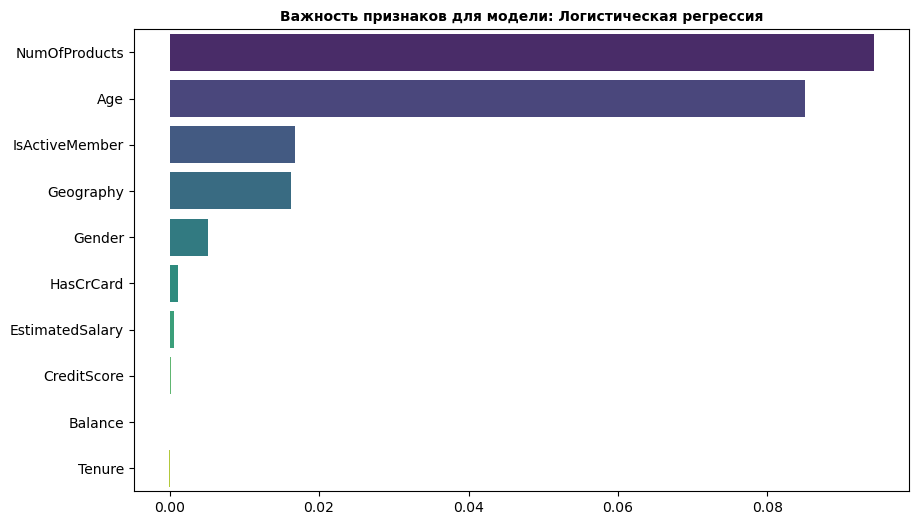

In [17]:
Log = make_pipeline(
    FeatureGenerator,
    CatBoostEncoder(cols = categorical_features),
    StandardScaler(),
    LogisticRegression(random_state = seed, max_iter = 1000000000)
)

score_list['LogReg'] = cross_val_score(Log,show_importance=True,model_name="Логистическая регрессия")

[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790
[LightGBM] [Info] Start training from score -1.363790
[LightGBM] [Info] Number of positive: 1629, number of negative: 6371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2584
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203625 -> initscore=-1.363790
[LightGBM] [Info] Start training from score -1.363790
[LightGBM] [Warnin

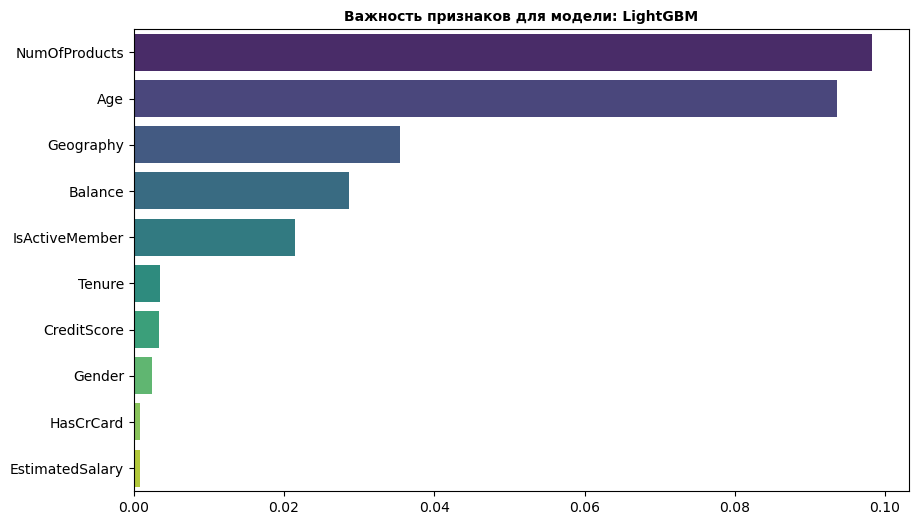

In [18]:
lgb_params = {'learning_rate': 0.01864960338160943, 'max_depth': 9, 'subsample': 0.6876252164703066, 'min_child_weight': 0.8117588782708633, 'reg_lambda': 6.479178739677389, 'reg_alpha': 3.2952573115561234}

LGB = make_pipeline(
    FeatureGenerator,
    CatBoostEncoder(cols = categorical_features),
    StandardScaler(),
    LGBMClassifier(**lgb_params, random_state = seed, n_estimators = 1000)
)

score_list["LGB"] = cross_val_score(LGB, show_importance = True, model_name="LightGBM")